# Get slope data given lat and lon 

## We will use slope data from https://www.landfire.gov/version_download.php# 

In [43]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#File paths
data_path      = '/Users/hrh/Desktop/AI/erdos/rapower_data/'
data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
ca_gridpath    = data_path2 + 'CA_data_version_0.csv'
slope_datapath = data_path + 'LF2020_SlpD_220_CONUS/'

### Read lats and lons for CA into a GeoDataframe

In [4]:
df_main             = pd.read_csv(ca_gridpath)
ca_grid             = df_main.loc[df_main['State']=='CA']
# ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['Latitude'], ca_grid['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))

((32.53767702167681, 42.00186839932766),
 (-124.47184652921426, -114.13859171386824))

In [6]:
ca_grid

,Latitude,Longitude,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Create a GeoDataFrame for California coordinates
geometry = [Point(xy) for xy in ca_coords]
# ca_gdf   = gpd.GeoDataFrame(geometry=geometry)
ca_gdf   = gpd.GeoDataFrame({
    'geometry': [Point(lon, lat) for lat, lon in ca_coords]
}, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system
ca_gdf

,geometry
0,POINT (-124.47185 40.41799)
1,POINT (-124.47185 40.43754)
2,POINT (-124.47185 40.45709)
3,POINT (-124.45027 40.39843)
4,POINT (-124.45027 40.41799)
...,...
102145,POINT (-114.16016 34.27799)
102146,POINT (-114.16016 34.29755)
102147,POINT (-114.16016 34.31710)
102148,POINT (-114.13859 34.25844)


### Read slope data 

In [8]:
#Slope data path 
slope_tif_path = slope_datapath + 'Tif/LC20_SlpD_220.tif'
# Open the slope raster
# Check the CRS of the GeoDataFrame and the Raster
with rasterio.open(slope_tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster Bounds: {src.bounds}")

print(f"GeoDataFrame CRS: {ca_gdf.crs}")

Raster CRS: EPSG:5070
Raster Bounds: BoundingBox(left=-2362395.0, bottom=221265.0, right=2327655.0, top=3267405.0)
GeoDataFrame CRS: EPSG:4326


In [9]:
with rasterio.open(slope_tif_path) as src:
    #Convert the ca_gdf dataframe to the crs of the source
    ca_gdf = ca_gdf.to_crs(src.crs)
    # Mask the raster with the GeoDataFrame to get the slope values for California coordinates
    # out_image, out_transform = mask(src, [g for g in ca_gdf['geometry'].values], crop=True)
    # ca_slope_data            = out_image[0]  # Assuming slope data is in the first band
    # Sample the raster at the given points
    ca_slope_values = [val[0] for val in src.sample([(geom.x, geom.y) for geom in ca_gdf.geometry])]


In [10]:
len(ca_slope_values)

102150

In [11]:
# Create a DataFrame from the sampled slope values
ca_slope = pd.DataFrame({
    'lat': [geom.y for geom in ca_gdf.geometry],
    'lon': [geom.x for geom in ca_gdf.geometry],
    'slope': ca_slope_values
})

In [12]:
ca_slope

,lat,lon,slope
0,2.289950e+06,-2.359659e+06,0
1,2.292043e+06,-2.359013e+06,0
2,2.294136e+06,-2.358366e+06,0
3,2.287321e+06,-2.358571e+06,0
4,2.289414e+06,-2.357925e+06,0
...,...,...,...
102145,1.404102e+06,-1.649158e+06,3
102146,1.406249e+06,-1.648743e+06,31
102147,1.408395e+06,-1.648327e+06,20
102148,1.401582e+06,-1.647637e+06,0


###  Convert the DataFrame back to a GeoDataFrame with the original CRS (EPSG:4326)

In [13]:
#CRS transformation after creating a geodata frame
ca_slope_gdf = gpd.GeoDataFrame(ca_slope, geometry=gpd.points_from_xy(ca_slope.lon, ca_slope.lat),crs='EPSG:5070') # Set to raster's CRS to match the sampling
print('The coordinate reference system of ca_slope_gdf is:',ca_slope_gdf.crs)

# Now, reproject to EPSG:4326
ca_slope_gdf = ca_slope_gdf.to_crs("EPSG:4326")
print('The coordinate reference system of ca_slope_gdf is:',ca_slope_gdf.crs)

# Assuming 'ca_slope_gdf' has been correctly reprojected to EPSG:4326
ca_slope_gdf['lat'] = ca_slope_gdf.geometry.y
ca_slope_gdf['lon'] = ca_slope_gdf.geometry.x

The coordinate reference system of ca_slope_gdf is: EPSG:5070
The coordinate reference system of ca_slope_gdf is: EPSG:4326


In [14]:
# Verify the transformation
ca_slope_gdf

,lat,lon,slope,geometry
0,40.417999,-124.471844,0,POINT (-124.47184 40.41800)
1,40.437553,-124.471844,0,POINT (-124.47184 40.43755)
2,40.457107,-124.471843,0,POINT (-124.47184 40.45711)
3,40.398444,-124.450272,0,POINT (-124.45027 40.39844)
4,40.417998,-124.450272,0,POINT (-124.45027 40.41800)
...,...,...,...,...
102145,34.277993,-114.160164,3,POINT (-114.16016 34.27799)
102146,34.297547,-114.160164,31,POINT (-114.16016 34.29755)
102147,34.317101,-114.160164,20,POINT (-114.16016 34.31710)
102148,34.258439,-114.138592,0,POINT (-114.13859 34.25844)


#### Because of re-gridding, some points have no slope data and I have decided to set those slopes to None

In [16]:
no_data_locations = ca_slope_gdf[ca_slope_gdf['slope'] == -9999]
no_data_locations

,lat,lon,slope,geometry
1889,39.401171,-123.889387,-9999,POINT (-123.88939 39.40117)
2137,39.205630,-123.846242,-9999,POINT (-123.84624 39.20563)
2734,39.029643,-123.759952,-9999,POINT (-123.75995 39.02964)
5044,38.619007,-123.457936,-9999,POINT (-123.45794 38.61901)
12970,37.797734,-122.595034,-9999,POINT (-122.59503 37.79773)
...,...,...,...,...
80735,32.537677,-117.201895,-9999,POINT (-117.20189 32.53768)
80736,32.557231,-117.201895,-9999,POINT (-117.20189 32.55723)
80737,32.576785,-117.201895,-9999,POINT (-117.20189 32.57679)
80738,32.596339,-117.201895,-9999,POINT (-117.20189 32.59634)


In [17]:
ca_slope_gdf.loc[ca_slope_gdf['slope'] == -9999, 'slope'] = None

### Finally, load the CA shape file and check if the slope information makes sense by plotting 

EPSG:4326


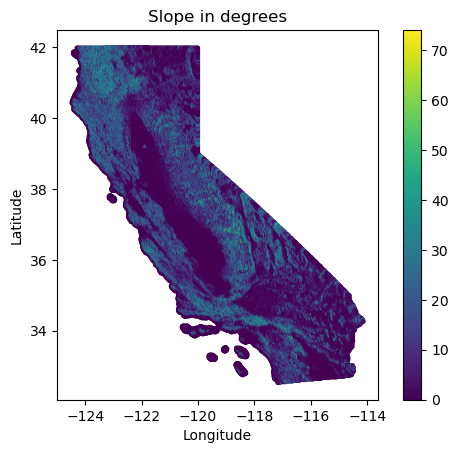

In [24]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the slope data
ca_slope_gdf.plot(ax=plt.gca(), column='slope', legend=True, markersize=5, cmap='viridis')

plt.title('Slope in degrees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finally, save the dataframe to a csv file after dropping the 'geometry' column

In [58]:
# Save to CSV
ca_slope_gdf.drop(columns='geometry').to_csv(data_path2+'ca_slope.csv', index=False)

In [59]:
#Check
ca_slope_check = pd.read_csv(data_path2+'ca_slope.csv')
ca_slope_check

,lat,lon,slope
0,40.417999,-124.471844,0.0
1,40.437553,-124.471844,0.0
2,40.457107,-124.471843,0.0
3,40.398444,-124.450272,0.0
4,40.417998,-124.450272,0.0
...,...,...,...
102145,34.277993,-114.160164,3.0
102146,34.297547,-114.160164,31.0
102147,34.317101,-114.160164,20.0
102148,34.258439,-114.138592,0.0


### Add slope data to the big dataframe

In [18]:
conus_features0 = pd.read_csv(ca_gridpath)
ca_features0    = conus_features0.loc[df_main['State']=='CA']
ca_features     = ca_features0.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'})
ca_features

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_features, 
    geometry=gpd.points_from_xy(ca_features.lon, ca_features.lat),
    crs="EPSG:4326"
)

# Ensure ca_slope is a GeoDataFrame with the same CRS
gdf_ca_slope = gpd.GeoDataFrame(
    ca_slope_check,
    geometry=gpd.points_from_xy(ca_slope_check.lon, ca_slope_check.lat),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_slope    = gdf_ca_slope.to_crs("EPSG:3310")


In [22]:
# Perform the spatial join to find the nearest neighbors and get their 'slope'
ca_features_with_slope = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_slope[['geometry', 'slope']], how='left', distance_col='distance')

# If you don't need the distance information, drop the 'distance' column
ca_features_with_slope.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_slope = ca_features_with_slope.to_crs("EPSG:4326")

ca_features_with_slope

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,geometry,slope
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.47184 40.41800),0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.47184 40.43755),0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.47184 40.45711),0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.45027 40.39844),0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-124.45027 40.41800),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-114.16016 34.27799),3.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-114.16016 34.29755),31.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-114.16016 34.31710),20.0
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-114.13859 34.25844),0.0


In [33]:
solar_farms = ca_features_with_slope[ca_features_with_slope['Solar_farm_present'] == 1]
solar_farms

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,geometry,slope
13910,38.032383,-122.508744,1.0,CA,0.019112,1.438727,6.0,0.019112,0.0,0.0,"2FJV+G3 San Rafael, CA, USA",POINT (-122.50874 38.03238),0.0
16288,40.633080,-122.314591,1.0,CA,0.026765,1.910786,702.0,0.026765,0.0,0.0,"JMJJ+R4 Columbia, Redding, CA, USA",POINT (-122.31459 40.63308),1.0
16536,40.496202,-122.293018,1.0,CA,0.014312,1.127613,3.0,0.014312,0.0,0.0,"6759 Airport Rd, Redding, CA 96002, USA",POINT (-122.29302 40.49620),0.0
16678,38.267033,-122.271446,1.0,CA,0.034076,NaN,3.0,0.034076,0.0,1.0,"7PCC+W7 Napa, CA, USA",POINT (-122.27145 38.26703),1.0
18748,38.227924,-122.098865,1.0,CA,0.032722,2.263317,4.0,0.032722,0.0,0.0,"6WJ4+QW Fairfield, CA, USA",POINT (-122.09887 38.22792),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96540,35.588119,-115.432945,1.0,CA,5.889066,179.797992,6.0,5.889066,0.0,0.0,"HHP8+27 Calada, CA, USA",POINT (-115.43295 35.58812),1.0
96753,33.828249,-115.389800,1.0,CA,14.031455,373.646009,6.0,14.031455,0.0,0.0,"RJ96+C8 Desert Center, CA, USA",POINT (-115.38980 33.82825),0.0
99819,33.574045,-114.915204,1.0,CA,0.308603,NaN,3.0,0.308603,0.0,1.0,"H38J+CM Blythe, CA, USA",POINT (-114.91520 33.57405),1.0
99948,33.574045,-114.893631,1.0,CA,0.033762,NaN,3.0,0.033762,0.0,1.0,"H38W+3C Blythe, CA, USA",POINT (-114.89363 33.57405),0.0


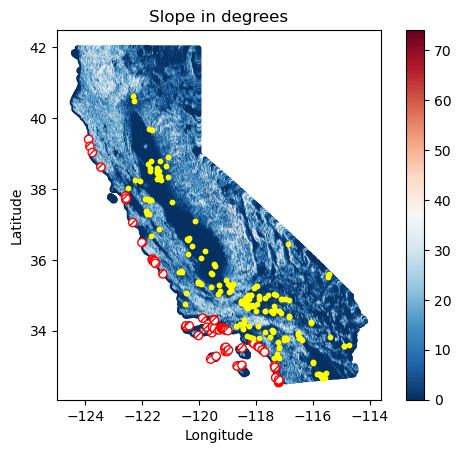

In [35]:
# Plot the California shapefile as the base only locations with solar farms

fig, ax = plt.subplots()
ca_shape.plot(ax=ax,color='white', edgecolor='black')

# Plot the slope data
ca_features_with_slope.plot(ax=ax, column='slope', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })



# Plot these points on top of the existing plot
solar_farms.plot(ax=ax, color='yellow', markersize=10, marker='o', label='solar_farms')

#Title and axis labels
plt.title('Slope in degrees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Add a legend
# plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the slope data
ca_features_with_slope.plot(ax=plt.gca(), column='slope', legend=True, markersize=5, cmap='viridis',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })

plt.title('Slope in degrees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Finally, save this data as a CSV file

In [55]:
ca_features_with_slope.drop(columns='geometry').to_csv(data_path2+'ca_data_version_1.csv', index=False)

In [56]:
ca_features_with_slope_check = pd.read_csv(data_path2+'ca_data_version_1.csv')
ca_features_with_slope_check 

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
